# Курсовой проект

## Helpers


In [480]:
#!pip install catboost

In [481]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [482]:
import warnings
warnings.simplefilter('ignore')
# matplotlib.rcParams.update({'font.size': 14})

### reduce_mem_usage

In [483]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### DataPipeline

In [484]:
class DataPipeline:
    """Подготовка исходных данных"""

    def get_median_of_years_in_current_job(self, df):
        """ Расчитать медиану для 'Years in current job'
            Как только станет больше медианы верхняя граница, значит это
            медианный год.
        """
        half_count = df['Years in current job'].count() / 2
        years_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
        years_sum = 0
        for year in years_order:
          years_sum += vcounts[year]
          if (half_count < years_sum):
              return year
    
    def __init__(self, gen_credit_score=False):
        """Параметры класса"""
        self.medians = None
        self.median_of_years_in_current_job = None
        self.open_credit_min = None
        self.open_credit_max = None
        self.current_loan_amount_max = None
        self.current_credit_balance_max = None
        self.monthly_debt_max = None
        self.gen_credit_score = gen_credit_score
        self.credit_score_2_min = 6000
        self.median_credit_score_1 = None
        self.median_credit_score_2 = None


    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        median_of_years_in_current_job = pd.Series({
            'Years in current job' : self.get_median_of_years_in_current_job(df),
            'Bankruptcies' : 0
        })
        self.medians = pd.concat([
            df[['Annual Income', 'Maximum Open Credit', 'Current Credit Balance', 'Monthly Debt', 'Months since last delinquent']].median(),
            median_of_years_in_current_job
        ])

        self.open_credit_min = np.quantile(df['Maximum Open Credit'], q=0.009)
        self.open_credit_max = np.quantile(df['Maximum Open Credit'], q=0.99)

        self.current_loan_amount_max = np.quantile(df['Current Loan Amount'], q=0.99)
        self.current_credit_balance_max = np.quantile(df['Current Credit Balance'], q=0.99)
        self.monthly_debt_max = np.quantile(df['Monthly Debt'], q=0.99)

        if self.gen_credit_score:
            # todo: нельзя заполнять условие на фите, поскольку массив изменится на тестовой выборке.
            self.median_credit_score_1 = df[df['Credit Score'] < self.credit_score_2_min]['Credit Score'].median()
            self.median_credit_score_2 = df[df['Credit Score'] >= self.credit_score_2_min]['Credit Score'].median()


    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df['Annual Income Blank'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual Income Blank'] = 1

        df[['Annual Income', 'Years in current job', 'Bankruptcies', 'Current Loan Amount']] =\
            df[['Annual Income', 'Years in current job', 'Bankruptcies', 'Current Loan Amount']].fillna(self.medians)


        na_delinquent_condition = df['Months since last delinquent'].isna()
        df['Months since last delinquent Blank'] = 0
        df.loc[na_delinquent_condition, 'Months since last delinquent Blank'] = 1
        df.loc[na_delinquent_condition, 'Months since last delinquent'] = self.medians['Months since last delinquent']

        # 2. Выбросы (outliers)
        maximum_open_credit_condition = (df['Maximum Open Credit'] < self.open_credit_min) | (df['Maximum Open Credit'] > self.open_credit_max)
        df.loc[maximum_open_credit_condition, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']

        current_loan_amount_condition = (df['Current Loan Amount'] >= self.current_loan_amount_max)
        df.loc[current_loan_amount_condition, 'Current Loan Amount'] = df[current_loan_amount_condition]['Maximum Open Credit']

        current_credit_balance_condition = (df['Current Credit Balance'] >= current_credit_balance_max)
        df.loc[current_credit_balance_condition, 'Current Credit Balance'] = self.medians['Current Credit Balance']

        monthly_debt_condition = (df['Monthly Debt'] >= monthly_debt_max)
        df.loc[monthly_debt_condition, 'Monthly Debt'] = self.medians['Monthly Debt']

        # 3. Новые фичи (features)
        if self.gen_credit_score:
            credit_score_1_condition = df['Credit Score'] < self.credit_score_2_min
            df['Credit Score 1'] = self.median_credit_score_1
            df.loc[credit_score_1_condition, 'Credit Score 1'] = df[credit_score_1_condition]['Credit Score']
            df['Credit Score 1 Outlier'] = 1
            df.loc[credit_score_1_condition, 'Credit Score 1 Outlier'] = 0

            credit_score_2_condition = df['Credit Score'] >= self.credit_score_2_min
            df['Credit Score 2'] = self.median_credit_score_2
            df.loc[credit_score_2_condition, 'Credit Score 2'] = df[credit_score_2_condition]['Credit Score']
            df['Credit Score 2 Outlier'] = 1
            df.loc[credit_score_2_condition, 'Credit Score 2 Outlier'] = 0

        df['rate'] = df['Monthly Debt'] / (df['Annual Income'] / 12)

        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='HomeOwnership')], axis=1)

        # XGBoost fix '<' symbol
        df['Years in current job 2'] = df['Years in current job'].cat.rename_categories({'< 1 year': 'less 1 year'})
        df = pd.concat([df, pd.get_dummies(df['Years in current job 2'], prefix='YearsInCurrentJob')], axis=1)

        df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Term'], prefix='Term')], axis=1)


        return df

### ResultPipeline

In [485]:
# todo: сходу не знаю как объединить scaller и pipeline.
class ResultPipeline:
    """Подготовка исходных данных"""

    TARGET_NAME = 'Credit Default'
    NUMERIC_FEATURE_NAMES = [
        'Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
        'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
        'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
        'Credit Score 1', 'Credit Score 2'
    ]

    NOT_NUMERIC_FEATURE_NAMES = [
        'HomeOwnership_Have Mortgage', 'HomeOwnership_Home Mortgage', 'HomeOwnership_Own Home', 'HomeOwnership_Rent',
        'YearsInCurrentJob_< 1 year', 'YearsInCurrentJob_1 year', 'YearsInCurrentJob_2 years',
        'YearsInCurrentJob_3 years', 'YearsInCurrentJob_4 years', 'YearsInCurrentJob_5 years',
        'YearsInCurrentJob_6 years', 'YearsInCurrentJob_7 years', 'YearsInCurrentJob_8 years',
        'YearsInCurrentJob_9 years', 'YearsInCurrentJob_10+ years',
        'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
        'Purpose_educational expenses', 'Purpose_home improvements', 'Purpose_major purchase',
        'Purpose_medical bills', 'Purpose_moving', 'Purpose_other', 'Purpose_renewable energy',
        'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
        'Term_Long Term', 'Term_Short Term',
        'Months since last delinquent Blank', 'Credit Score 1 Outlier', 'Credit Score 2 Outlier'
    ]

    def __init__(self, gen_credit_score=False):
        """Параметры класса"""
        self.pipeline = DataPipeline(gen_credit_score=gen_credit_score)
        self.scaler = StandardScaler()

    def fit(self, df):
        """Сохранение статистик"""
        pass


    def transform(self, df):
        """Трансформация данных"""
        return df

### get_classification_report

In [486]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### balance_df_by_target

In [487]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name])# - 1 # todo: 

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

## 01 Обзор обучающего датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Пути к директориям и файлам

In [488]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
PREDICTIONS_PATH = "./predictions_makarevich.csv"

### Загрузка данных

In [489]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [490]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [491]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [492]:
import warnings
warnings.filterwarnings('ignore')
# matplotlib.rcParams.update({'font.size': 14})

In [493]:
BASE_FEATURE_NAMES = [
    'Home Ownership',
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Bankruptcies',
    'Purpose',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score'
]

## 02 Обработка выбросов

```
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   float32 
 13  Current Credit Balance        7500 non-null   float32 
 14  Monthly Debt                  7500 non-null   float32 
 15  Credit Score                  5943 non-null   float32 
 16  Credit Default                7500 non-null   int8  
 ```

In [494]:
df = df_train

### 0 Home Ownership

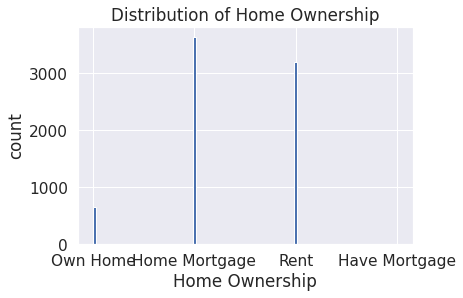

In [495]:
feature_name = 'Home Ownership'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [496]:
df[feature_name].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Ни пропусков, ни выбросов.

### 1* Annual Income

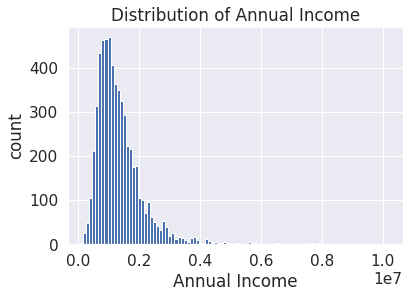

In [497]:
feature_name = 'Annual Income'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

А что за пик в окресности 1 млн? А что на тесте, тоже этот шип?

In [498]:
df[feature_name].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

```python
df[feature_name].describe()
```

```
count    5943
mean      1,366,390
std         845,338.4
min         164,597
25%         844,341
50%       1,168,386
75%       1,640,137
max      10,149,340
```

Не вижу здесь выбросов, а пропуски заполню медианой

А почему пропуски не указаны, что это восстановленный пропуск?

###  2 Years in current job

In [499]:
df['Years in current job'].describe()

count          7129
unique           11
top       10+ years
freq           2332
Name: Years in current job, dtype: object

In [500]:
vcounts = df['Years in current job'].value_counts()
vcounts

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Не так много пропусков - заполним их медианой. Подробнее смотри datapipeline.

### 3 Tax Liens

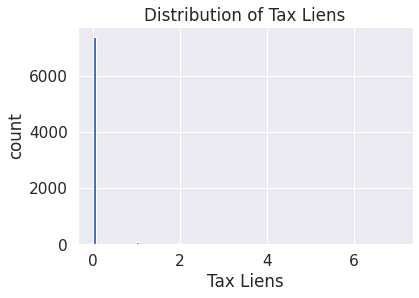

In [501]:
feature_name = 'Tax Liens'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [502]:
df[feature_name].describe()

count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

In [503]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Не выбросов ни пропусков, только не уверен, что имеет значение, поскольку значения очень не сбалансированы.

### 4 Number of Open Accounts

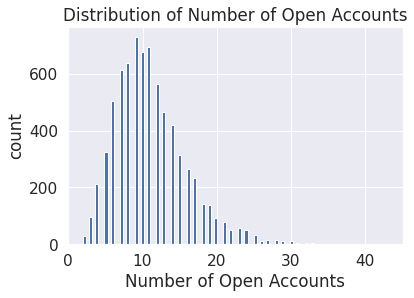

In [504]:
feature_name = 'Number of Open Accounts'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [505]:
df[feature_name].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

Ни пропусков ни выбросов
idea: похоже на нормальное распределение

### 5 Years of Credit History

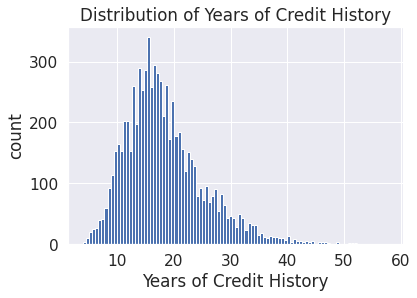

In [506]:
feature_name = 'Years of Credit History'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [507]:
df[feature_name].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

Ни пропусков ни выбросов

### 6   Maximum Open Credit

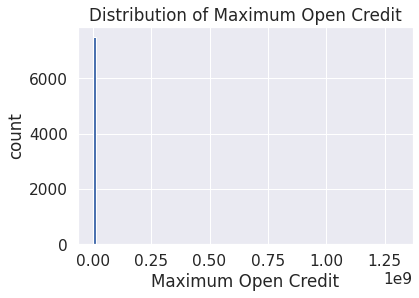

In [508]:
feature_name = 'Maximum Open Credit'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [509]:
df[feature_name].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

Из-за выбросов больших чисел, ничего не понять уберем их.

In [510]:
open_credit_max = np.quantile(df[feature_name], q=0.99)
df[df[feature_name] < open_credit_max][feature_name].describe()

count    7.425000e+03
mean     6.050217e+05
std      4.857293e+05
min      0.000000e+00
25%      2.769580e+05
50%      4.734620e+05
75%      7.825620e+05
max      3.567982e+06
Name: Maximum Open Credit, dtype: float64

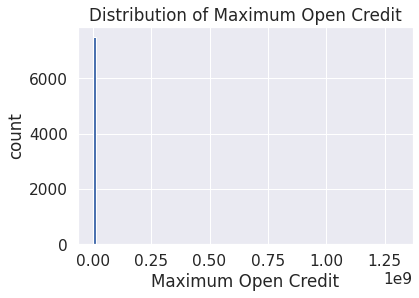

In [511]:
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Что-то мне не верится, что наибольший открытый кредит может быть близок к нулю.

In [512]:
open_credit_min = np.quantile(df[feature_name], q=0.009)
df[df[feature_name] < open_credit_min]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,NaN,8 years,0.0,10.0,13.0,0.0,0.0,NaN,0.0,debt consolidation,Long Term,672078.0,19.0,8860.0,NaN,0
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,NaN,0.0,home improvements,Long Term,760452.0,0.0,36778.0,725.0,0
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,NaN,0.0,small business,Long Term,751454.0,0.0,15348.0,737.0,1
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


### 7 Number of Credit Problems

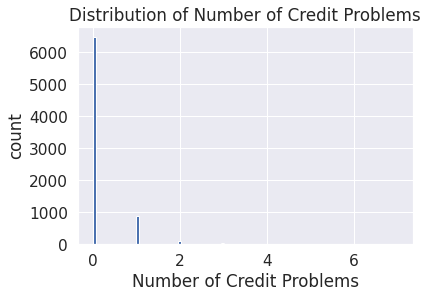

In [513]:
feature_name = 'Number of Credit Problems'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Ни выбросов ни пропусков, не уверен что сбалансированы значения.

### 8* Months since last delinquent

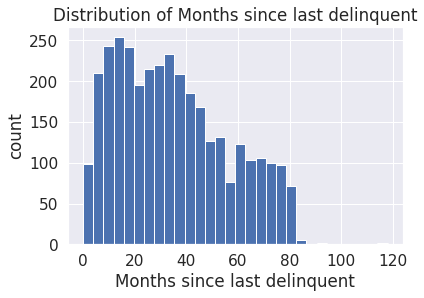

In [514]:
feature_name = 'Months since last delinquent'
df[feature_name].hist(bins=30)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [515]:
df.groupby(by='Credit Default').count()['Months since last delinquent']

Credit Default
0    2436
1     983
Name: Months since last delinquent, dtype: int64

Не знаю как заполнить пропуски.

### 9* Bankruptcies

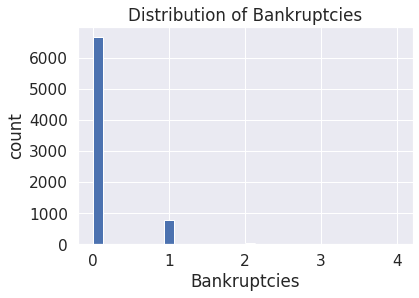

In [516]:
feature_name = 'Bankruptcies'
df[feature_name].hist(bins=30)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Есть пропуски, можно заполнить медианой, а можно из взаимосвязанного параметра `Number of Credit Problems`, корреляция 0.73.


### 10 Purpose

In [517]:
feature_name = 'Purpose'
df[feature_name].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Без пропусков

### 11 Term

In [518]:
feature_name = 'Term'
df[feature_name].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Без пропусков

### 12 Current Loan Amount

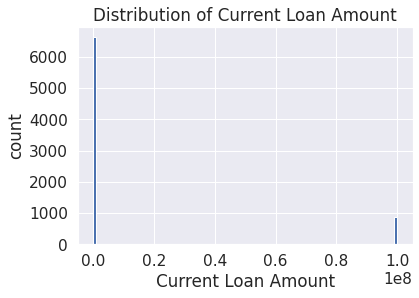

In [519]:
feature_name = 'Current Loan Amount'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Слишком большое значение - скорее всего выброс.

In [520]:
current_loan_amount_max = np.quantile(df[feature_name], q=0.9)
print(current_loan_amount_max)
# current_loan_amount_condition = (df[feature_name] < current_loan_amount_min) | (df[feature_name] > current_loan_amount_max)
current_loan_amount_condition = (df[feature_name] >= current_loan_amount_max)
df[current_loan_amount_condition][[feature_name, 'Maximum Open Credit']].head()

99999999.0


,Current Loan Amount,Maximum Open Credit
0,99999999.0,685960.0
2,99999999.0,1182434.0
6,99999999.0,388124.0
22,99999999.0,288442.0
27,99999999.0,328394.0


Как возможна ситуация, когда `наибольший открытый кредит` меньше `текущая сумма кредита`? Пусть текущая тогда будет хотя бы равна максимуму.

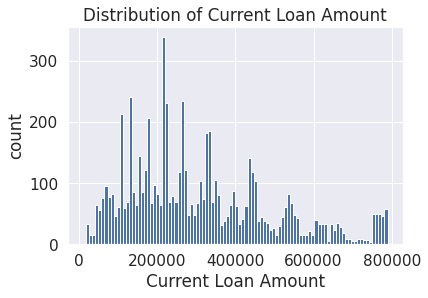

In [521]:
df[(df[feature_name] < current_loan_amount_max)][feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

800 выглядят подозрительно, но пока оставим так.

### 13 Current Credit Balance

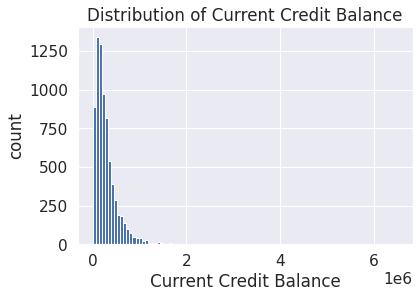

In [522]:
feature_name = 'Current Credit Balance'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [523]:
current_credit_balance_max = np.quantile(df[feature_name], q=0.99)
print(current_credit_balance_max)
# current_loan_amount_condition = (df[feature_name] < current_loan_amount_min) | (df[feature_name] > current_loan_amount_max)
current_loan_amount_condition = (df[feature_name] >= current_credit_balance_max)
df[current_loan_amount_condition].head()

1483079.3900000013


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
93,Home Mortgage,NaN,10+ years,0.0,18.0,17.9,3028014.0,0.0,NaN,0.0,debt consolidation,Short Term,311168.0,2327443.0,55716.0,NaN,0
162,Home Mortgage,2131591.0,< 1 year,0.0,15.0,31.7,4191176.0,0.0,NaN,0.0,debt consolidation,Short Term,269258.0,3547262.0,20783.0,728.0,0
561,Own Home,1709829.0,8 years,0.0,16.0,32.0,6230994.0,0.0,46.0,0.0,home improvements,Short Term,131978.0,1754308.0,35764.0,750.0,0
604,Home Mortgage,2822773.0,1 year,0.0,13.0,29.5,3409934.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,2612177.0,50810.0,727.0,0
814,Home Mortgage,NaN,2 years,0.0,18.0,14.2,2541088.0,0.0,NaN,0.0,debt consolidation,Short Term,470690.0,1768824.0,40954.0,NaN,1


Записи выше считаем выбросами

### 14 Monthly Debt

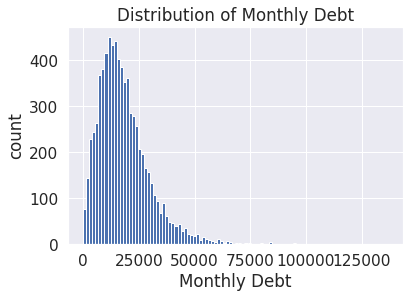

In [524]:
feature_name = 'Monthly Debt'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

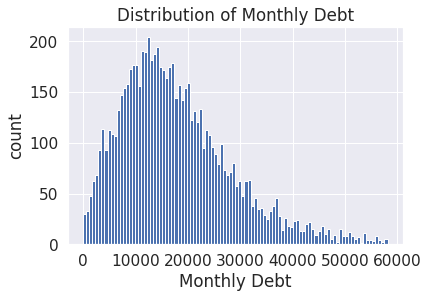

In [525]:
monthly_debt_max = np.quantile(df[feature_name], q=0.99)
monthly_debt_condition = (df[feature_name] >= monthly_debt_max)
df[~monthly_debt_condition][feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Вот теперь без выбросов намного лучше.

### 15** Credit Score

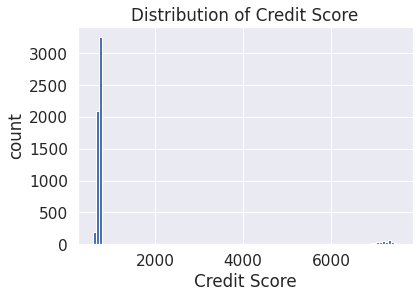

In [526]:
feature_name = 'Credit Score'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

И выбросы и пропуски, да и по табице корелляции ни с чем не коррелирует 0.0xx.

In [527]:
print(feature_name)
monthly_debt_max = np.quantile(df[feature_name], q=0.99)
monthly_debt_max

Credit Score


nan

In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

nan


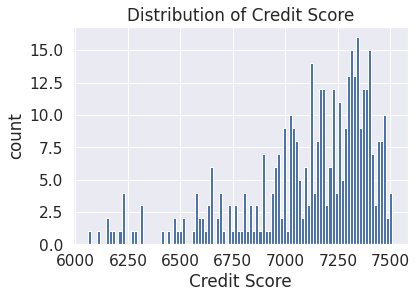

In [529]:
credit_score_max = np.quantile(df[feature_name], q=0.5)
print(credit_score_max)
credit_score_max = 6000
credit_score_condition = (df[feature_name] >= credit_score_max)
df[credit_score_condition][feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

nan


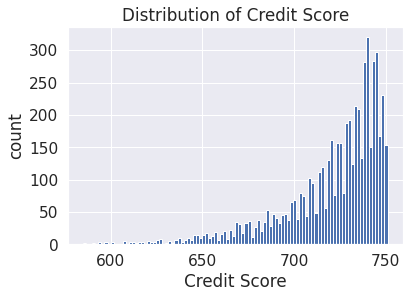

In [530]:
credit_score_max = np.quantile(df[feature_name], q=0.5)
print(credit_score_max)
credit_score_max = 6000
credit_score_condition = (df[feature_name] >= credit_score_max)
df[~credit_score_condition][feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Очень сильно похоже распределение, может следует проверить? Как-будто просто нужно разделить на 10.

In [531]:
df[credit_score_condition][feature_name].count()

400

#### А есть ли корреляция?

In [532]:
df = None
df_cs = None
feature_name = 'Credit Score'
df_cs = pd.read_csv(TRAIN_DATASET_PATH)
df_cs = reduce_mem_usage(df_cs)
df_cs.describe()

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [533]:
credit_score_max = 6000
credit_score_outliers_condition = df_cs[feature_name] >= credit_score_max
df_csno = df_cs[(~credit_score_outliers_condition) & df_cs[feature_name].notna()]
df_csno.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5543.00,5543.000000,5543.000000,5543.000000,5.543000e+03,5543.000000,2552.000000,5534.000000,5543.0,5.543000e+03,5543.000000,5543.000000,5543.000000
mean,1374951.75,0.028504,11.103374,18.347832,8.187129e+05,0.171929,34.740204,0.120528,15956964.0,2.913056e+05,18270.355469,720.705933,0.213603
std,849771.25,0.268491,4.874792,7.025501,6.372660e+06,0.500290,21.679228,0.355334,36266680.0,3.265615e+05,11897.108398,27.651163,0.409886
min,164597.00,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,849746.50,0.000000,8.000000,13.600000,2.774420e+05,0.000000,16.000000,0.000000,189651.0,1.134015e+05,10070.500000,709.000000,0.000000
50%,1179786.00,0.000000,10.000000,17.000000,4.771580e+05,0.000000,32.000000,0.000000,325292.0,2.088670e+05,16075.000000,729.000000,0.000000
75%,1649950.50,0.000000,14.000000,21.900000,7.996890e+05,0.000000,50.000000,0.000000,555533.0,3.629095e+05,23774.500000,741.000000,0.000000
max,10149344.00,7.000000,43.000000,57.700001,3.800523e+08,7.000000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,751.000000,1.000000


In [534]:
credit_score_2_condition = df_csno['Credit Score'] >= 6000
median_credit_score_2 = df_csno[credit_score_2_condition]#['Credit Score'].median()
median_credit_score_2

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [535]:
pipeline = DataPipeline()
pipeline.fit(df_csno)
df_csno = pipeline.transform(df_csno)
df_csno.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income Blank,Months since last delinquent Blank,rate,HomeOwnership_Have Mortgage,HomeOwnership_Home Mortgage,HomeOwnership_Own Home,HomeOwnership_Rent,YearsInCurrentJob_1 year,YearsInCurrentJob_10+ years,YearsInCurrentJob_2 years,YearsInCurrentJob_3 years,YearsInCurrentJob_4 years,YearsInCurrentJob_5 years,YearsInCurrentJob_6 years,YearsInCurrentJob_7 years,YearsInCurrentJob_8 years,YearsInCurrentJob_9 years,YearsInCurrentJob_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
count,5543.00,5543.000000,5543.000000,5543.000000,5.543000e+03,5543.000000,5543.000000,5543.000000,5.543000e+03,5.543000e+03,5543.000000,5543.000000,5543.000000,5543.0,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.0,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000
mean,1374951.75,0.028504,11.103374,18.347832,6.116782e+05,0.171929,33.261593,0.120332,3.641279e+05,2.684239e+05,18270.355469,720.705933,0.213603,0.0,0.539599,0.170261,0.001443,0.491431,0.084431,0.422695,0.065849,0.312827,0.095075,0.082807,0.112574,0.066931,0.057550,0.051597,0.047988,0.032473,0.074328,0.016958,0.012809,0.004510,0.795057,0.001624,0.054664,0.005051,0.009742,0.001624,0.087137,0.0,0.003067,0.004691,0.000902,0.002165,0.259065,0.740935
std,849771.25,0.268491,4.874792,7.025501,4.882282e+05,0.500290,14.771575,0.355066,2.913322e+05,2.248786e+05,11897.108398,27.651163,0.409886,0.0,0.498474,0.078993,0.037966,0.499972,0.278058,0.494032,0.248040,0.463686,0.293345,0.275615,0.316100,0.249925,0.232912,0.221231,0.213761,0.177270,0.262328,0.129127,0.112460,0.067012,0.403697,0.040266,0.227343,0.070900,0.098229,0.040266,0.282061,0.0,0.055300,0.068333,0.030023,0.046482,0.438161,0.438161
min,164597.00,0.000000,2.000000,4.000000,1.727000e+04,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,849746.50,0.000000,8.000000,13.600000,2.861320e+05,0.000000,32.000000,0.000000,1.799160e+05,1.134015e+05,10070.500000,709.000000,0.000000,0.0,0.000000,0.111003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1179786.00,0.000000,10.000000,17.000000,4.771580e+05,0.000000,32.000000,0.000000,3.008500e+05,2.088670e+05,16075.000000,729.000000,0.000000,0.0,1.000000,0.166002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1649950.50,0.000000,14.000000,21.900000,7.853890e+05,0.000000,32.000000,0.000000,4.589420e+05,3.522410e+05,23774.500000,741.000000,0.000000,0.0,1.000000,

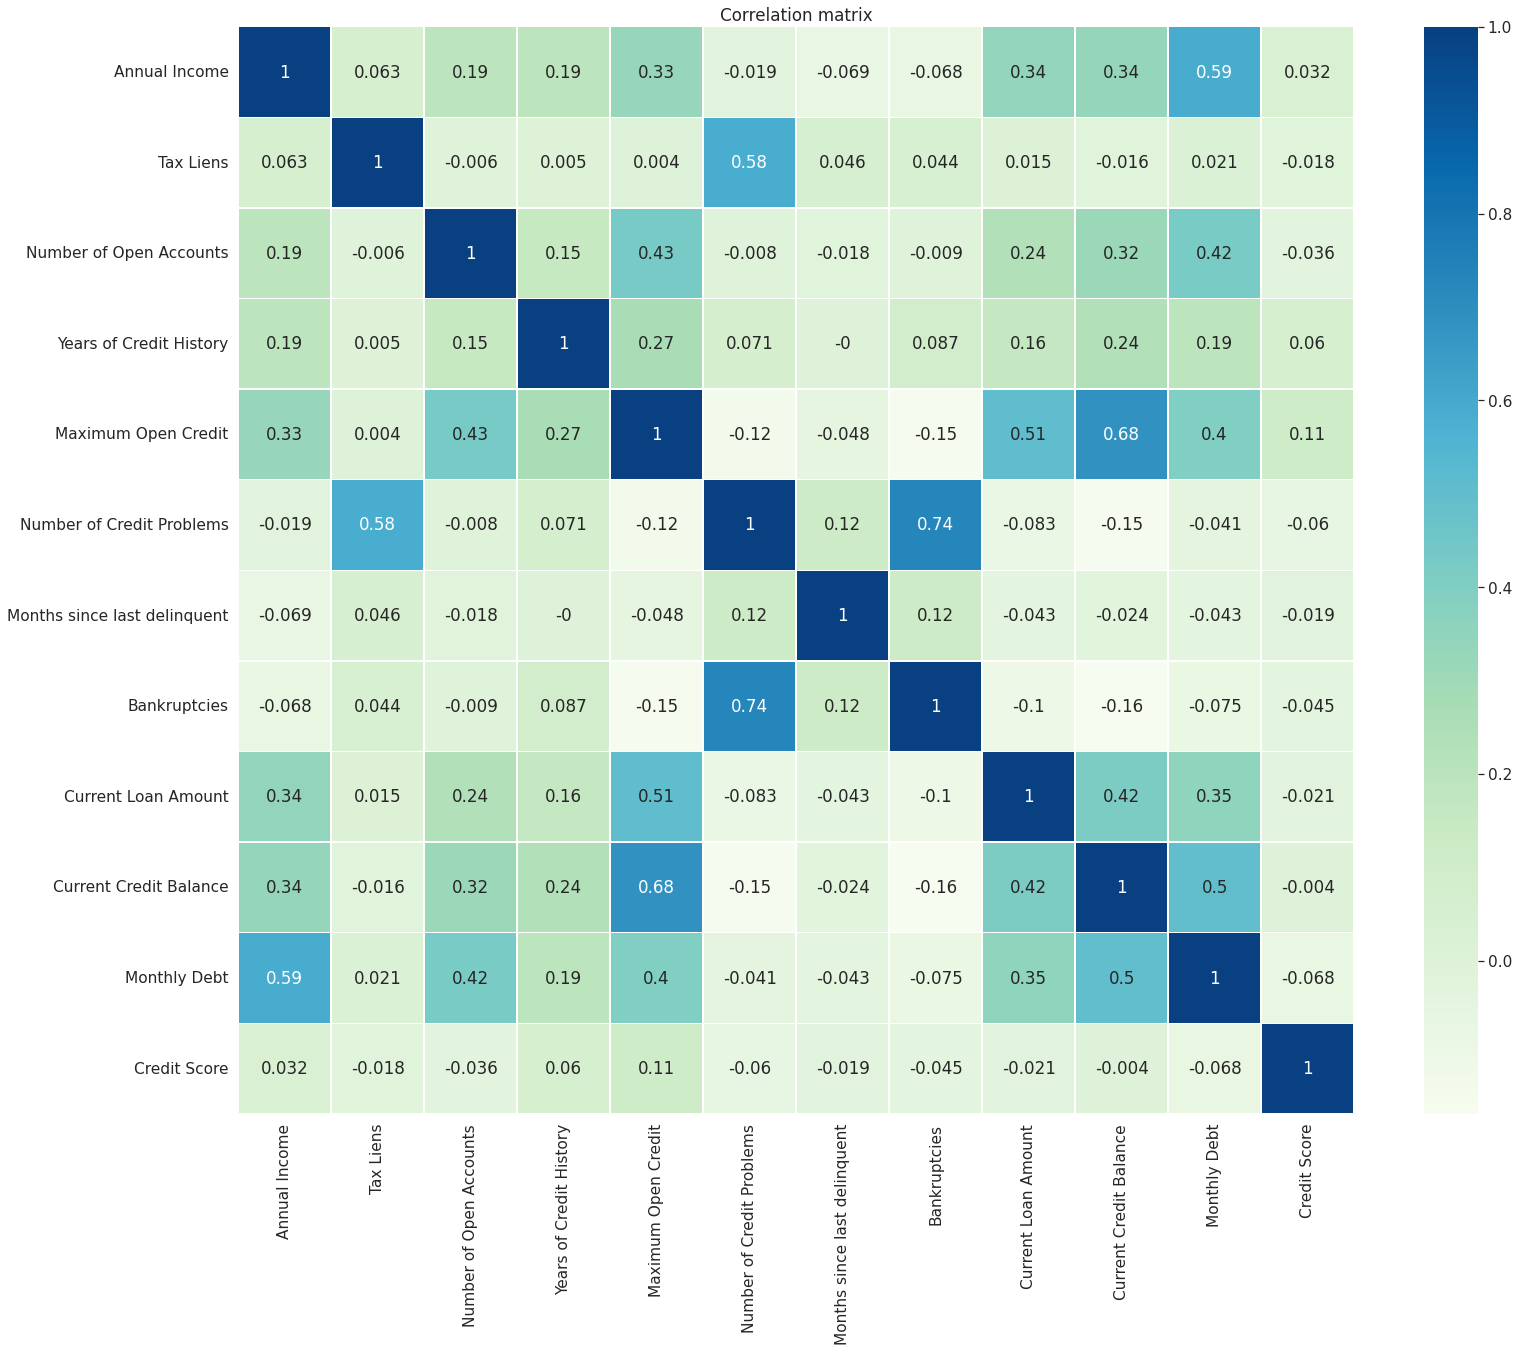

In [536]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_csno[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

##### Выборка с выбросами

In [537]:
df_cso = df_cs[credit_score_outliers_condition & df_cs[feature_name].notna()]
df_cso.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.000000e+02,400.000000,400.000000,400.000000,4.000000e+02,400.000000,184.000000,397.000000,400.00000,4.000000e+02,400.000000,400.000000,400.0
mean,1.247745e+06,0.040000,11.432500,17.821493,5.800268e+05,0.137500,34.434784,0.083123,327142.81250,2.841096e+05,18393.812500,7115.100098,1.0
std,7.725889e+05,0.280351,5.265908,7.278304,5.264691e+05,0.468125,21.762154,0.302585,189155.15625,2.348475e+05,11744.836914,306.745331,0.0
min,2.060170e+05,0.000000,2.000000,5.500000,1.113200e+04,0.000000,0.000000,0.000000,30514.00000,5.700000e+01,57.000000,6060.000000,1.0
25%,7.572830e+05,0.000000,8.000000,12.875000,2.832445e+05,0.000000,17.000000,0.000000,183095.00000,1.317365e+05,9981.500000,6987.500000,1.0
50%,1.047736e+06,0.000000,10.000000,16.299999,4.601520e+05,0.000000,33.000000,0.000000,269137.00000,2.231740e+05,16165.500000,7190.000000,1.0
75%,1.529671e+06,0.000000,14.000000,20.824999,7.073275e+05,0.000000,48.250000,0.000000,443025.00000,3.472725e+05,24225.250000,7340.000000,1.0
max,8.200229e+06,3.000000,42.000000,45.500000,6.639358e+06,4.000000,81.000000,2.000000,788634.00000,1.406190e+06,73412.000000,7510.000000,1.0


In [538]:
pipeline = DataPipeline()
pipeline.fit(df_cso)
df_cso = pipeline.transform(df_cso)
df_cso.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income Blank,Months since last delinquent Blank,rate,HomeOwnership_Have Mortgage,HomeOwnership_Home Mortgage,HomeOwnership_Own Home,HomeOwnership_Rent,YearsInCurrentJob_1 year,YearsInCurrentJob_10+ years,YearsInCurrentJob_2 years,YearsInCurrentJob_3 years,YearsInCurrentJob_4 years,YearsInCurrentJob_5 years,YearsInCurrentJob_6 years,YearsInCurrentJob_7 years,YearsInCurrentJob_8 years,YearsInCurrentJob_9 years,YearsInCurrentJob_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
count,4.000000e+02,400.000000,400.000000,400.000000,4.000000e+02,400.000000,400.000000,400.000000,4.000000e+02,4.000000e+02,400.000000,400.000000,400.0,400.0,400.000000,400.000000,400.0,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.0000,400.000000,400.0,400.000000,400.000000,400.000000,400.0000,400.000000,400.0,400.000000,400.0000,400.0,400.0,400.000000,400.000000
mean,1.247745e+06,0.040000,11.432500,17.821493,5.521554e+05,0.137500,33.660000,0.082500,3.325832e+05,2.841096e+05,18393.812500,7115.100098,1.0,0.0,0.540000,0.186632,0.0,0.432500,0.112500,0.455000,0.08250,0.312500,0.080000,0.077500,0.060000,0.062500,0.080000,0.055000,0.03500,0.022500,0.132500,0.030000,0.015000,0.0025,0.807500,0.0,0.032500,0.005000,0.010000,0.0025,0.085000,0.0,0.007500,0.0025,0.0,0.0,0.362500,0.637500
std,7.725889e+05,0.280351,5.265908,7.278304,3.840824e+05,0.468125,14.755488,0.301531,2.229736e+05,2.348475e+05,11744.836914,306.745331,0.0,0.0,0.499022,0.081385,0.0,0.496043,0.316376,0.498595,0.27547,0.464093,0.271633,0.267718,0.237784,0.242365,0.271633,0.228266,0.18401,0.148489,0.339458,0.170801,0.121705,0.0500,0.394757,0.0,0.177546,0.070622,0.099623,0.0500,0.279231,0.0,0.086385,0.0500,0.0,0.0,0.481324,0.481324
min,2.060170e+05,0.000000,2.000000,5.500000,3.324200e+04,0.000000,0.000000,0.000000,3.051400e+04,5.700000e+01,57.000000,6060.000000,1.0,0.0,0.000000,0.000701,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000
25%,7.572830e+05,0.000000,8.000000,12.875000,2.889315e+05,0.000000,33.000000,0.000000,1.830950e+05,1.317365e+05,9981.500000,6987.500000,1.0,0.0,0.000000,0.125751,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000
50%,1.047736e+06,0.000000,10.000000,16.299999,4.601520e+05,0.000000,33.000000,0.000000,2.691370e+05,2.231740e+05,16165.500000,7190.000000,1.0,0.0,1.000000,0.184001,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,1.000000
75%,1.529671e+06,0.000000,14.000000,20.824999,6.987585e+05,0.000000,33.000000,0.000000,4.418810e+05,3.472725e+05,24225.250000,7340.000000,1.0,0.0,1.000000,0.243251,0.0,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0

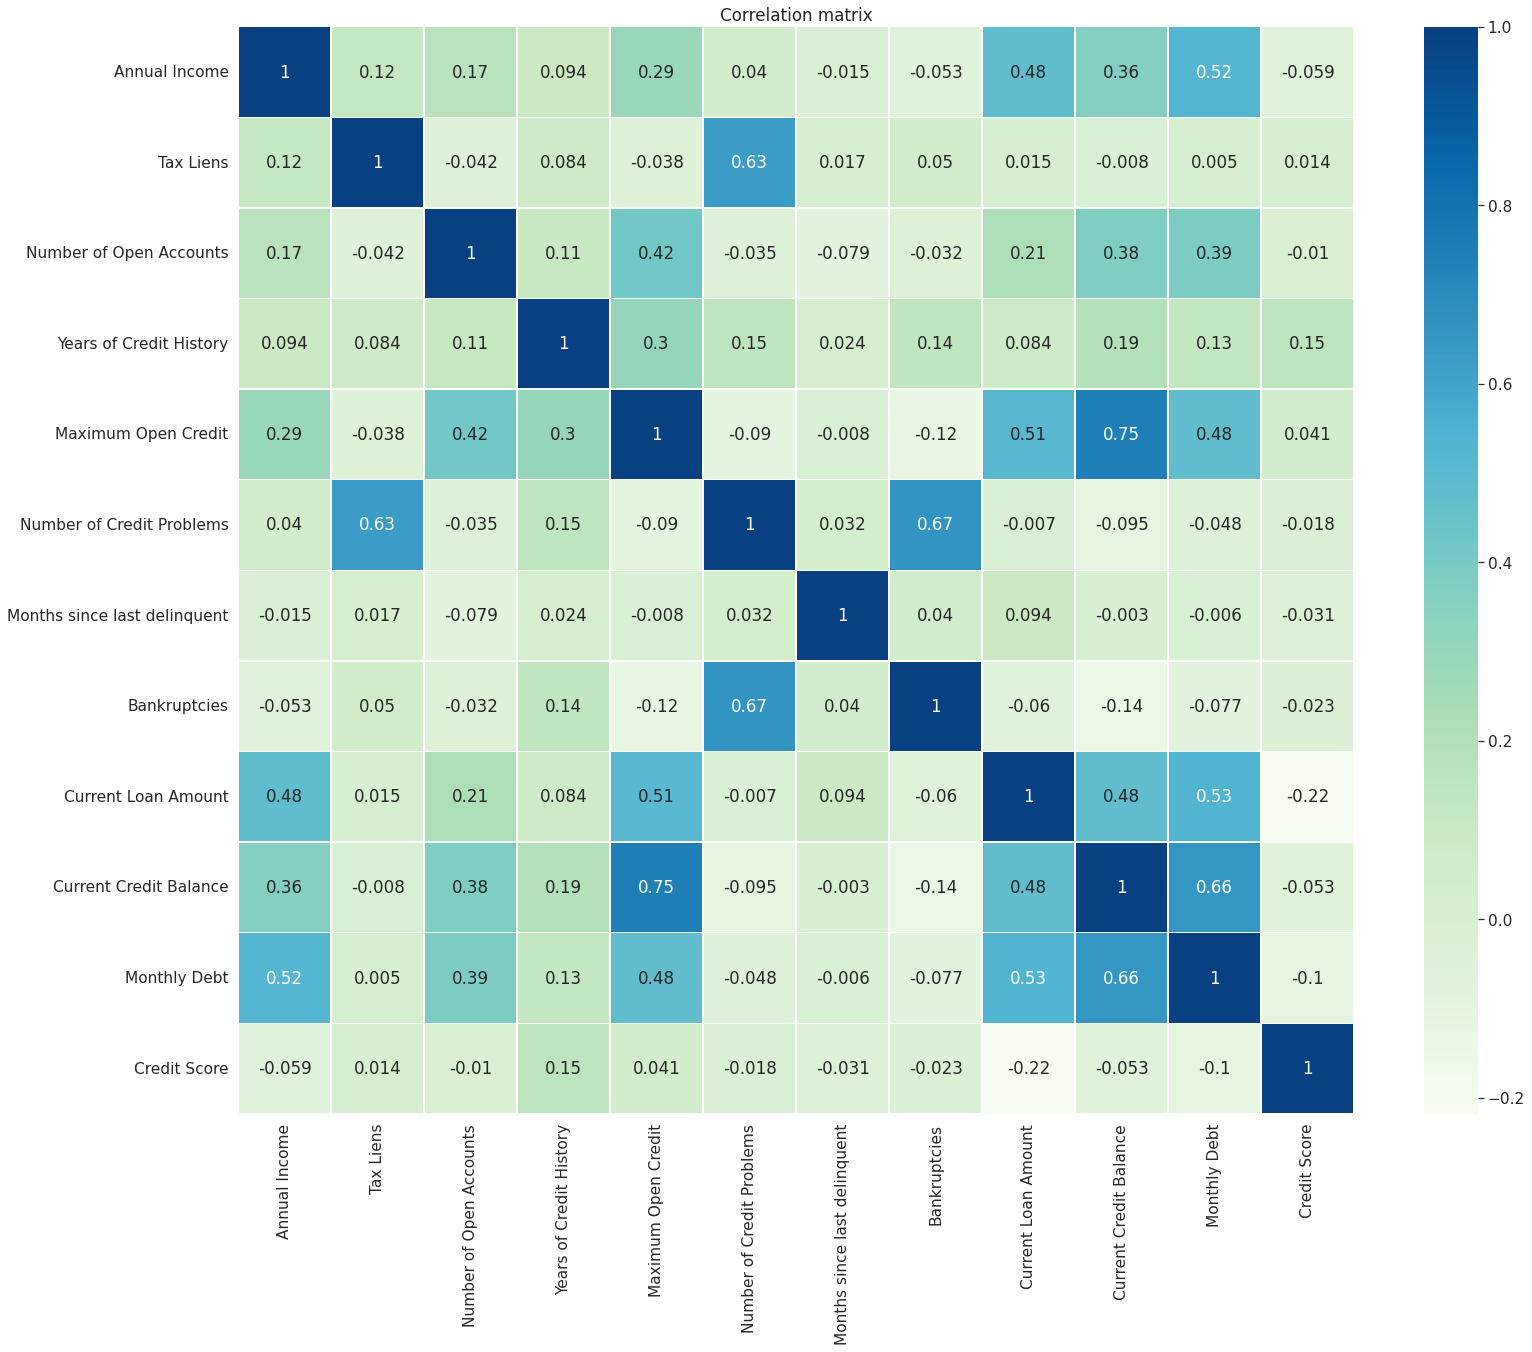

In [539]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_cso[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Из двух таблиц корреляции построенных на "нормальных" данных и на данных с выбросами, видим что:
* "нормальные" данные (`Credit Score 1`) имеют корреляцию с `maximum open credit`,
* а данные с выбросами (`Credit Score 2`) - с `years of credit history`

Возможно, стоит разделить эти выборки на две, но все равно не понятно, как восстановить слишком большое количество пропусков.

Наверное, я могу разделить эти две выборки, затем заполнить пропуски из среднего и указать, что было заполнение.

#### А что с тестовой выборкой?

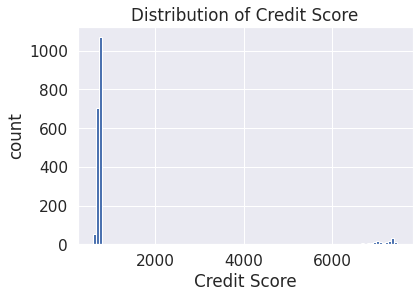

In [540]:
feature_name = 'Credit Score'
df_test[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Тестовая выборка содержит такие же выбросы как и тренировочная.

## 03 Обработка пропусков

```
RangeIndex: 7500 entries, 0 to 7499
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 15  Credit Score                  5943 non-null   float32 
```

## 04 Анализ данных


In [541]:
df = reduce_mem_usage(df_train)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [542]:
pipeline = DataPipeline(gen_credit_score=True)
pipeline.fit(df_train)
df = pipeline.transform(df_train)
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income Blank,Months since last delinquent Blank,Credit Score 1,Credit Score 1 Outlier,Credit Score 2,Credit Score 2 Outlier,rate,HomeOwnership_Have Mortgage,HomeOwnership_Home Mortgage,HomeOwnership_Own Home,HomeOwnership_Rent,YearsInCurrentJob_1 year,YearsInCurrentJob_10+ years,YearsInCurrentJob_2 years,YearsInCurrentJob_3 years,YearsInCurrentJob_4 years,YearsInCurrentJob_5 years,YearsInCurrentJob_6 years,YearsInCurrentJob_7 years,YearsInCurrentJob_8 years,YearsInCurrentJob_9 years,YearsInCurrentJob_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000,7500.0000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000
mean,1.325285e+06,0.030133,11.130934,18.317446,608087.500,0.1700,33.227467,0.116933,3.489997e+05,2.685424e+05,18314.453125,1151.087524,0.281733,0.207600,0.544133,722.870133,0.260933,7186.005333,0.946667,0.175129,0.001600,0.484933,0.086267,0.427200,0.067200,0.310933,0.094000,0.082667,0.062533,0.068800,0.106267,0.052800,0.045200,0.034533,0.075067,0.017200,0.012800,0.004533,0.792533,0.001333,0.054933,0.005333,0.009467,0.001467,0.088667,0.000267,0.003467,0.004933,0.001067,0.00200,0.259200,0.740800
std,7.567584e+05,0.271613,4.908937,7.041938,480160.625,0.4986,14.703838,0.346901,2.682707e+05,2.251171e+05,11926.758789,1604.447510,0.449874,0.405616,0.498082,24.048295,0.439173,72.730195,0.224712,0.090705,0.039971,0.499806,0.280776,0.494705,0.250385,0.462906,0.291848,0.275396,0.242138,0.253131,0.308199,0.223649,0.207756,0.182607,0.263516,0.130025,0.112418,0.067182,0.405520,0.036493,0.227865,0.072840,0.096842,0.038272,0.284281,0.016329,0.058780,0.070069,0.032645,0.04468,0.438225,0.438225
min,1.645970e+05,0.000000,2.000000,4.000000,10890.000,0.0000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,585.000000,0.000000,6060.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,287012.000,0.0000,32.000000,0.000000,1.778920e+05,1.142565e+05,10067.500000,711.000000,0.000000,0.000000,0.000000,718.000000,0.000000,7190.000000,1.000000,0.110996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,478159.000,0.0000,32.000000,0.000000,2.866930e+05,2.093135e+05,16076.500000,731.000000,0.000000,0.000000,1.000000,729.000000,0.000000,7190.000000,1.000000,0.167001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

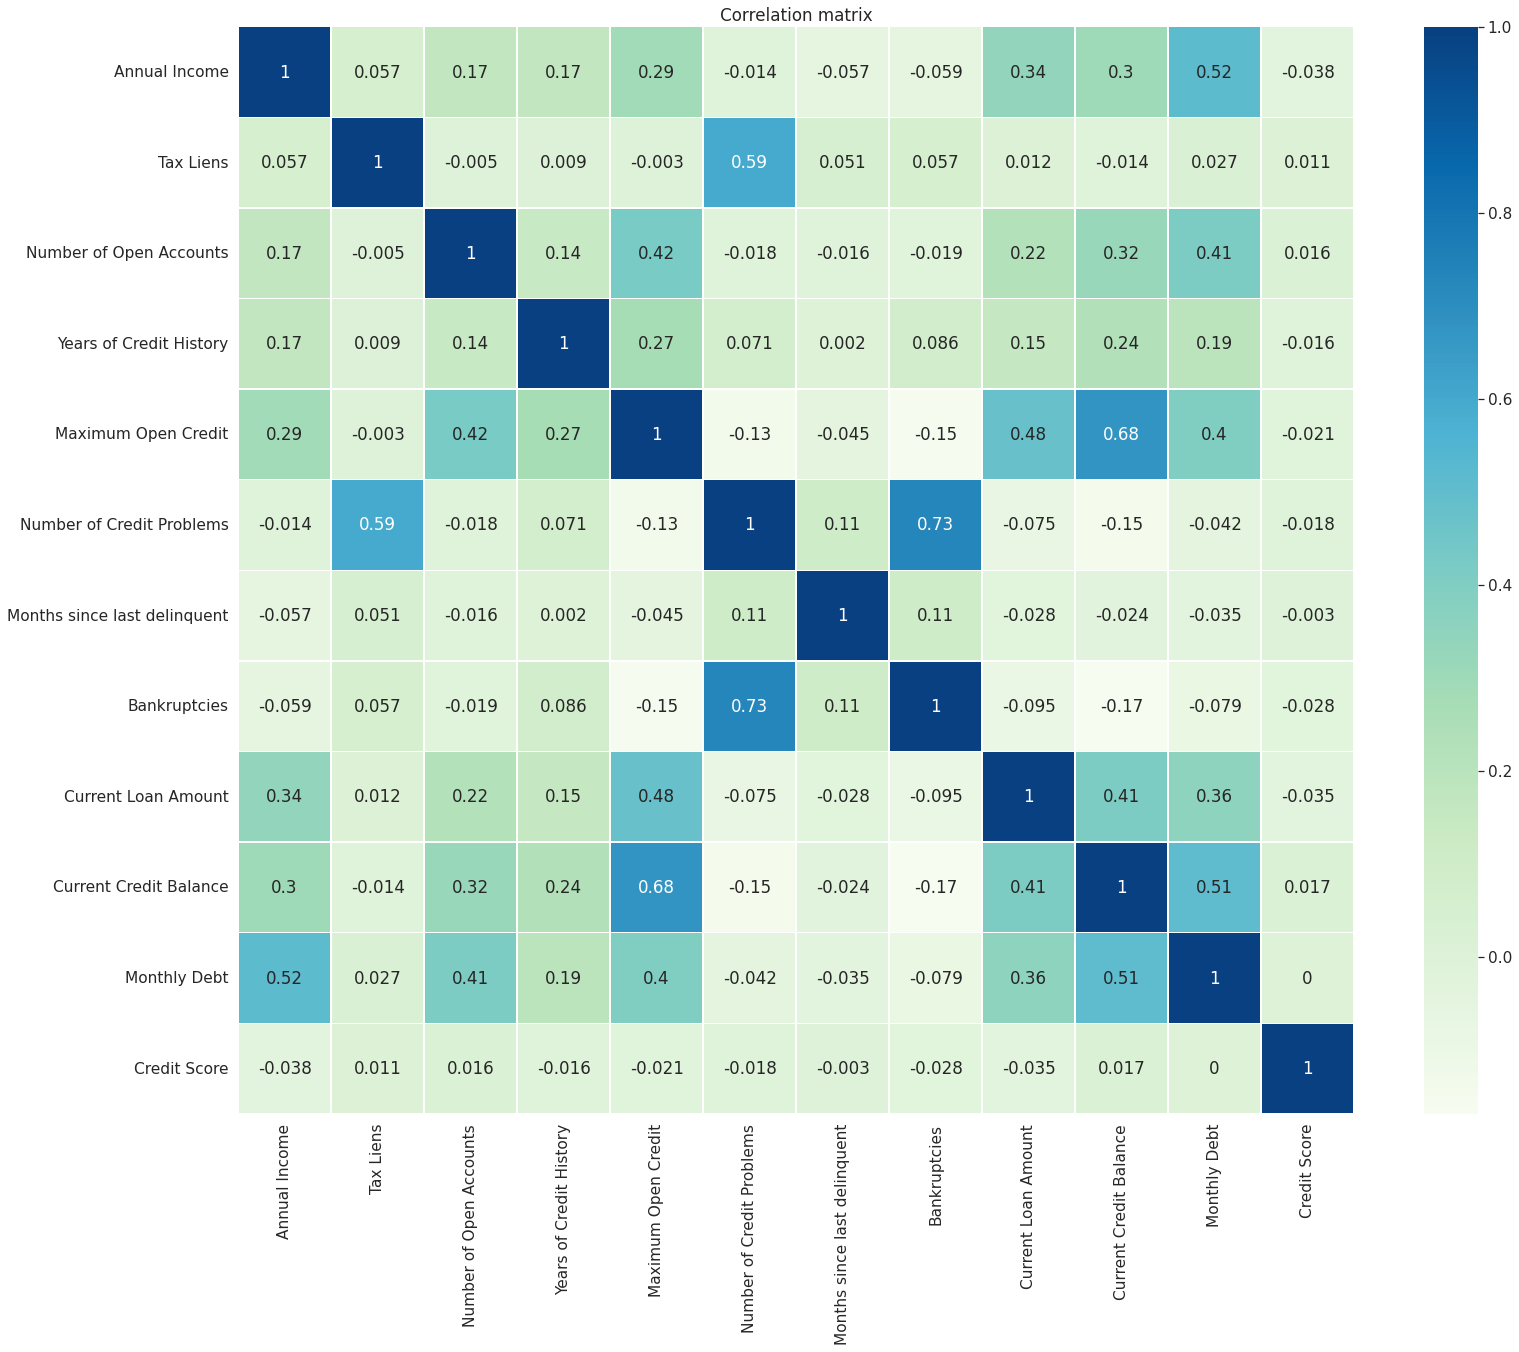

In [543]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### _ Monthly Debt

* `Annual Income` - годовой доход
* `Monthly Debt` - ежемесячный долг

In [544]:
md_df = df[['Annual Income', 'Monthly Debt', 'Credit Default']]
md_df['rate'] = md_df['Monthly Debt'] / (md_df['Annual Income'] / 12)
md_df = md_df[['Annual Income', 'Monthly Debt', 'rate', 'Credit Default']]
md_df.head()

,Annual Income,Monthly Debt,rate,Credit Default
0,482087.0,7914.0,0.196993,0
1,1025487.0,18373.0,0.214996,1
2,751412.0,13651.0,0.218006,0
3,805068.0,11338.0,0.168999,0
4,776264.0,7180.0,0.110993,0


In [545]:
md_df.groupby(['Credit Default']).median()

,Annual Income,Monthly Debt,rate
Credit Default,,,
0,1168386.0,15939.0,0.161176
1,1168386.0,16390.0,0.182996


### Annual Income

In [546]:
# почему равны средние годовые доходы.
ai_df = df[['Annual Income', 'Credit Default']]
ai_df.groupby(['Credit Default']).median()


,Annual Income
Credit Default,
0,1168386.0
1,1168386.0


### Credit Score

In [547]:
csx_df = df[['Credit Score', 'Credit Default']]
cs1_df = csx_df[(csx_df['Credit Score'] < 6000) & csx_df['Credit Score'].notna()].sample(1000)
shapiro(cs1_df['Credit Score'])

(0.8350702524185181, 6.45082100451597e-31)

Поскольку `pvalue` << 0.05, то отклоняем нулевую гипотезу, то есть распределение не нормальное. Поскольку уже есть ненормальное распределение, то сравнивать математические ожидания мы будем непараметрическим критерием Манна-Уитни, который не требователен к закону распределения.

In [548]:
cs2_df = csx_df[(csx_df['Credit Score'] >= 6000) & csx_df['Credit Score'].notna()]

In [549]:
mannwhitneyu(cs1_df['Credit Score'], cs2_df['Credit Score'])

MannwhitneyuResult(statistic=0.0, pvalue=1.2897972570646312e-188)

Поскольку pvalue << 0.05, то мы отклоняем нулевую гипотезу, то есть отклоняем гипотезу о равности мат. ожиданий. Учтем корреляционную матрицу из выбросов, и сделаем вывод, что один признак следует разделить на 2.

## Pipeline

In [550]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = reduce_mem_usage(df_train)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [551]:
pipeline = DataPipeline(gen_credit_score=True)
pipeline.fit(df_train)
df = pipeline.transform(df_train)
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income Blank,Months since last delinquent Blank,Credit Score 1,Credit Score 1 Outlier,Credit Score 2,Credit Score 2 Outlier,rate,HomeOwnership_Have Mortgage,HomeOwnership_Home Mortgage,HomeOwnership_Own Home,HomeOwnership_Rent,YearsInCurrentJob_1 year,YearsInCurrentJob_10+ years,YearsInCurrentJob_2 years,YearsInCurrentJob_3 years,YearsInCurrentJob_4 years,YearsInCurrentJob_5 years,YearsInCurrentJob_6 years,YearsInCurrentJob_7 years,YearsInCurrentJob_8 years,YearsInCurrentJob_9 years,YearsInCurrentJob_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000,7500.0000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000
mean,1.325285e+06,0.030133,11.130934,18.317446,608087.500,0.1700,33.227467,0.116933,3.489997e+05,2.685424e+05,18314.453125,1151.087524,0.281733,0.207600,0.544133,722.870133,0.260933,7186.005333,0.946667,0.175129,0.001600,0.484933,0.086267,0.427200,0.067200,0.310933,0.094000,0.082667,0.062533,0.068800,0.106267,0.052800,0.045200,0.034533,0.075067,0.017200,0.012800,0.004533,0.792533,0.001333,0.054933,0.005333,0.009467,0.001467,0.088667,0.000267,0.003467,0.004933,0.001067,0.00200,0.259200,0.740800
std,7.567584e+05,0.271613,4.908937,7.041938,480160.625,0.4986,14.703838,0.346901,2.682707e+05,2.251171e+05,11926.758789,1604.447510,0.449874,0.405616,0.498082,24.048295,0.439173,72.730195,0.224712,0.090705,0.039971,0.499806,0.280776,0.494705,0.250385,0.462906,0.291848,0.275396,0.242138,0.253131,0.308199,0.223649,0.207756,0.182607,0.263516,0.130025,0.112418,0.067182,0.405520,0.036493,0.227865,0.072840,0.096842,0.038272,0.284281,0.016329,0.058780,0.070069,0.032645,0.04468,0.438225,0.438225
min,1.645970e+05,0.000000,2.000000,4.000000,10890.000,0.0000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,585.000000,0.000000,6060.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,287012.000,0.0000,32.000000,0.000000,1.778920e+05,1.142565e+05,10067.500000,711.000000,0.000000,0.000000,0.000000,718.000000,0.000000,7190.000000,1.000000,0.110996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,478159.000,0.0000,32.000000,0.000000,2.866930e+05,2.093135e+05,16076.500000,731.000000,0.000000,0.000000,1.000000,729.000000,0.000000,7190.000000,1.000000,0.167001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

## 05 Отбор признаков

In [552]:
TARGET_NAME = 'Credit Default'
NUMERIC_FEATURE_NAMES = [
    'Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
    'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
    'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
    'Credit Score 1', 'Credit Score 2', 'rate'
]

NOT_NUMERIC_FEATURE_NAMES = [
    'HomeOwnership_Have Mortgage', 'HomeOwnership_Home Mortgage', 'HomeOwnership_Own Home', 'HomeOwnership_Rent',
    'YearsInCurrentJob_less 1 year', 'YearsInCurrentJob_1 year', 'YearsInCurrentJob_2 years',
    'YearsInCurrentJob_3 years', 'YearsInCurrentJob_4 years', 'YearsInCurrentJob_5 years',
    'YearsInCurrentJob_6 years', 'YearsInCurrentJob_7 years', 'YearsInCurrentJob_8 years',
    'YearsInCurrentJob_9 years', 'YearsInCurrentJob_10+ years',
    'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
    'Purpose_educational expenses', 'Purpose_home improvements', 'Purpose_major purchase',
    'Purpose_medical bills', 'Purpose_moving', 'Purpose_other', 'Purpose_renewable energy',
    'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
    'Term_Long Term', 'Term_Short Term',
    'Months since last delinquent Blank', 'Credit Score 1 Outlier', 'Credit Score 2 Outlier', 'Annual Income Blank'
]

FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NOT_NUMERIC_FEATURE_NAMES

### Нормализация данных

In [553]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()
#df.head(3)

### Разбиение на train и test

In [554]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

## 06 Балансировка классов

In [555]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Выборка не сбалансирована, потому что просрочек более чем в два раза меньше, чем погашен во время.

In [556]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

1    4734
0    4047
Name: Credit Default, dtype: int64

In [557]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

## 07 Подбор моделей, получение бейзлана


### Логистическая регрессия

In [558]:
model_lr = LogisticRegression(penalty='none')
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.66      0.65      4047
           1       0.70      0.69      0.70      4734

    accuracy                           0.68      8781
   macro avg       0.68      0.68      0.68      8781
weighted avg       0.68      0.68      0.68      8781

TEST

              precision    recall  f1-score   support

           0       0.83      0.64      0.72      1340
           1       0.43      0.67      0.52       535

    accuracy                           0.65      1875
   macro avg       0.63      0.66      0.62      1875
weighted avg       0.72      0.65      0.67      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               861  479
1               176  359


In [559]:
model_lr.coef_

array([[-4.92469524e-01, -8.12241853e-03,  7.45430619e-02,
         2.61355348e-02, -2.53853952e-01,  1.02662891e-01,
        -2.54403470e-02, -4.27046828e-02, -2.52660024e-01,
         1.91514000e-01,  2.82057975e-01, -2.06608538e-01,
         7.49416448e-02, -3.46184257e-02,  1.19914958e-01,
         9.57975750e-01,  9.77388713e-01,  1.27157390e+00,
         2.57208779e-01,  8.17281362e-02,  3.30061411e-01,
         2.81406443e-01,  2.52979412e-01,  3.55033948e-01,
         6.36217388e-01,  8.73754380e-02,  5.49243729e-01,
         1.92445673e-01,  3.03152960e-01,  8.83565847e-01,
        -4.58406056e-02,  1.99329599e-02,  3.69245396e-02,
        -7.79389116e-01,  8.73794857e-02,  7.11343636e-02,
         3.29820282e-01, -5.30503511e-01,  1.20791879e-01,
         1.03073488e+00,  7.91403860e-01,  1.93294969e-01,
         5.39142941e-01,  5.78460545e-01,  2.10659311e+00,
         1.22026021e+00, -1.87941347e-03,  5.30345988e+00,
        -6.60754658e+00, -4.63094002e+00]])

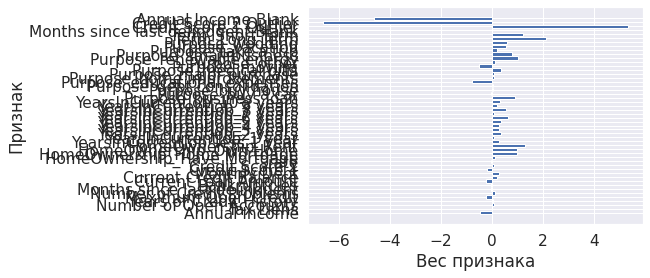

In [560]:

plt.barh(X_train.columns, model_lr.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признак')
plt.rcParams["figure.figsize"] = (10, 30)

### k ближайших соседей

In [561]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.69      0.79      4047
           1       0.78      0.94      0.85      4734

    accuracy                           0.83      8781
   macro avg       0.85      0.82      0.82      8781
weighted avg       0.84      0.83      0.82      8781

TEST

              precision    recall  f1-score   support

           0       0.79      0.60      0.69      1340
           1       0.38      0.60      0.46       535

    accuracy                           0.60      1875
   macro avg       0.58      0.60      0.57      1875
weighted avg       0.67      0.60      0.62      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               809  531
1               213  322


### XGBoost

In [562]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      4047
           1       0.73      0.76      0.75      4734

    accuracy                           0.72      8781
   macro avg       0.72      0.72      0.72      8781
weighted avg       0.72      0.72      0.72      8781

TEST

              precision    recall  f1-score   support

           0       0.83      0.64      0.72      1340
           1       0.43      0.68      0.53       535

    accuracy                           0.65      1875
   macro avg       0.63      0.66      0.62      1875
weighted avg       0.72      0.65      0.67      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               854  486
1               171  364


### LightGBM

In [563]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4047
           1       0.92      0.94      0.93      4734

    accuracy                           0.93      8781
   macro avg       0.93      0.92      0.93      8781
weighted avg       0.93      0.93      0.93      8781

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1340
           1       0.48      0.55      0.51       535

    accuracy                           0.70      1875
   macro avg       0.65      0.66      0.65      1875
weighted avg       0.72      0.70      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1024  316
1                240  295


### CatBoost


In [564]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4047
           1       0.92      0.95      0.93      4734

    accuracy                           0.93      8781
   macro avg       0.93      0.93      0.93      8781
weighted avg       0.93      0.93      0.93      8781

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1340
           1       0.49      0.58      0.53       535

    accuracy                           0.71      1875
   macro avg       0.65      0.67      0.66      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1019  321
1                227  308


## 08 Выбор наилучшей модели, настройка гиперпараметров

Наилучшей моделью стала - логистическая регрессия, поскольку ее значение f1-score для просрочек больше всех минимум на 0.01. К тому же разница

## 09 Проверка качества, борьба с переобучением

## 10 Интерпретация результатов

In [565]:
df_test = pd.read_csv(TEST_DATASET_PATH)
n_rows = df_test.shape[0]
df_test = reduce_mem_usage(df_test)

df_test = pipeline.transform(df_test)

df_norm = df_test.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.transform(df_norm[NUMERIC_FEATURE_NAMES])
df_norm['Purpose_renewable energy'] = 0 # todo: hot fixes - has no field!
X_test = df_norm[FEATURE_NAMES_SELECTED]

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [566]:
y_test_preds = model_lr.predict(X_test)
y_test_preds

array([1, 0, 1, ..., 1, 0, 1], dtype=int8)

In [567]:
pred_df = pd.DataFrame()
pred_df["Credit Default"] = y_test_preds
assert pred_df.shape[0] == n_rows, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv(PREDICTIONS_PATH, index=False)